# Homework 02 - Sebastiano Zagatti

## Exercise 1:
$0.3\%$ of the population has an unknown virus and a test is being developed. This test gives a false positive $10\%$ of the time and a flase negative $5\%$ of the time.

1. Calculate the probability that you are positive to the test.
2. Suppose you are positive to the test. What is the probability that you contracted the disease?

#### Solution

Given the text of the exercise we have that: $P(virus)=0.003$, $P(positive\,|\,no\_virus)=0.1$, $P(positive\,|\,virus)=0.05$

1. The probability of being positive to a test is the sum of the probability of not having the virus and resulting positive to the test and the probability of having the virus and resulting positive to the test, so:

$$ P(positive) = P(positive\,|\,no\_virus)\cdot P(no\_virus) + P(positive\,|\,virus)\cdot P(virus) $$

We need to compute the probability of not having the virus:

$$ P(no\_virus) = 1-P(virus) = 1-0.003=0.997 $$

And the probability of the true positive $P(positive|virus)$ (we use its relation with the false negative):

$$ P(positive\,|\,virus) = 1 - P(negative\,|\,virus) = 1-0.05=0.95 $$

Now we can compute the probability of testing positive:

\begin{align*} 
P(positive) &= P(positive\,|\,no\_virus)\cdot P(no\_virus) + P(positive\,|\,virus)\cdot P(virus) \\
&= 0.1 \cdot 0.997 + 0.003 \cdot 0.95 = 0.10255
\end{align*}

2. In order to compute the probability of having contracted the desease given the fact that we are positive to the test we need to use Bayes' theorem:

$$ P(virus\,|\,positive)=\frac{P(positive \,|\, virus)\cdot P(virus)}{P(positive)} = \frac{0.95 \cdot 0.003}{0.10255} \approx 0.02779 $$

## Exercise 2:
Implement the empirical cumulative distribution function $F_X(x) = \texttt{cdf(dist, x, n\_samples)}$ taking as inputs a \texttt{pyro.distributions} object \texttt{dist}, corresponding to the distribution of $X$, a real value $x$ and the number of samples \texttt{n\_samples}.

The function \texttt{cdf(dist, x, n\_samples)} should return the value of $F_X$ at $x$ and also plot the cdf.

Suppose that $X \sim Exp(0.5)$. Using your function, plot $F_X$ and compute $F_X(x=2)$.

#### Solution

In [1]:
import torch
import pyro
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pyro.set_rng_seed(1)

def cdf(dist, x, n_samples):
    # create a numpy array with the samples
    samples = np.array([pyro.sample("n", dist) for i in range(n_samples)])
    
    # sort the samples
    sorted_samples = np.sort(samples)
    
    # filter the samples keeping all the values smaller than x
    sorted_samples = sorted_samples[np.where(sorted_samples <= x)]
    
    # compute the value of the empirical distribution function for all the samples
    emp_f = np.array([(i+1)/n_samples for i in range(len(sorted_samples))])
    
    # plotting
    plt.plot(sorted_samples, emp_f)
    plt.title("Empirical Cumulative Distribution Function")
    plt.xlabel("x")
    plt.ylabel("F(x)")
    plt.rcParams["figure.figsize"]=(20,15)
    plt.show()
    
    # compute the value of cdf
    f_value = len(sorted_samples)/n_samples
    print("The value of the cumulative distribution function in ", x, " is ", f_value)

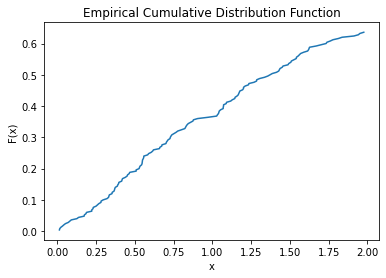

The value of the cumulative distribution function in  2  is  0.636


In [2]:
cdf(pyro.distributions.Exponential(0.5), 2, 250)

## Exercise 3:
Suppose that the height of female students are normally distributed with unknown mean $\mu$ and known variance $6^2$.

Suppose that $\mu$ is in the range $[155,175]$ with approximately $95\%$ probability and assign to $\mu$ a normal $\mathcal{N}(160, 3^2)$ prior distribution.

1. Using the cdf from the previous exercise, empirically verify that the prior probability thet $\mu \in [155, 175]$ is approximately $95\%$.
2. Analytically derive the posterior distribution for a set of observations of heights $x=[x_1, \dots, x_n]$.
3. Plot the posterior distribution corresponding to the data $x=[174, 158, 194, 167]$ together with the prior distribution.

#### Solution
1. We know that $\mu$ has $95\%$ probability of being in $[155,175]$ and it is normally distributed $\mu \sim \mathcal{N}(160, 3^2)$, so we can write:

$$ P(\mu \in [155,175]) = \int_{155}^{175} f_{\mathcal{N}}(\mu; 160, 3^2)\, d\mu = 95\%$$

But the integral can be computed using the cumulative distribution function:

$$ \int_{155}^{175} f_{\mathcal{N}}(\mu; 160, 3^2)\, d\mu = F_{\mathcal{N}}(\mu = 175; 160, 3^2)-F_{\mathcal{N}}(\mu = 155; 160, 3^2)$$

To prove this empirically we can use the `cdf` function defined in the previous exercise.

In [3]:
def cdf_2(dist, x, n_samples):
    samples = np.array([pyro.sample("n", dist) for i in range(n_samples)])
    sorted_samples = np.sort(samples)
    sorted_samples = sorted_samples[np.where(sorted_samples <= x)]
    emp_f = np.array([(i+1)/n_samples for i in range(len(sorted_samples))])
    f_value = len(sorted_samples)/n_samples
    return f_value



print("Prior probability of mu in [155, 175] is ", cdf_2(pyro.distributions.Normal(160, 3), 175, 500)-cdf_2(pyro.distributions.Normal(160, 3), 155, 500))

Prior probability of mu in [155, 175] is  0.952


2. The density function of the normal is given by:

$$ f(\mu| \mu_0, \sigma_0^2) = \frac{1}{\sqrt{2\pi \sigma_0^2}} \exp\left( -\frac{1}{2\sigma_0^2}\left( \mu-\mu_0 \right)^2 \right) $$

The likelihood of the normal distribution with unknown mean is:

$$ P(x_1, x_2, \dots, x_n| \mu) = \prod_{i=1}^n \frac{1}{\sqrt{2\pi \sigma^2}} \exp \left(-\frac{1}{2 \sigma^2} \left( x_i - \mu \right)^2\right) = \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{n}\left(x_i -\mu\right)^2\right)$$

Let's compute the posterior:

\begin{align*}
f(\mu|x) &= \frac{f(\mu)f(x|\mu)}{f(x)} \propto f(\mu)f(x|\mu) = \frac{1}{\sqrt{2\pi \sigma_0^2}} \exp\left( -\frac{1}{2\sigma_0^2}\left( \mu-\mu_0 \right)^2 \right) \cdot \left( \frac{1}{\sqrt{2\pi\sigma^2}} \right)^n \exp\left( -\frac{1}{2\sigma^2} \sum_{i=1}^{n}\left(x_i -\mu\right)^2\right)\\
&= \frac{1}{(2\pi)^{\frac{(n+1)}{2}} \sqrt{\sigma_0^2\sigma^{2n}}} \exp\left( \frac{-\mu^2 + \mu\mu_0-\mu_0^2}{2\sigma_0^2} - \sum_{i=1}^n \frac{x_i^2 - 2\mu x_i + \mu^2}{2\sigma^2} \right) \\
&\propto \exp\left( \frac{-\mu^2 (\sigma^2 + n\sigma_0^2) + 2\mu(\mu_0 \sigma^2 + \sigma_0^2 x_1 + \dots + \sigma_0^2 x_n) - (\mu_0^2 \sigma^2 + \sigma_0^2x_1^2 + \dots + \sigma_0^2 x_n^2)}{2\sigma_0^2\sigma^2} \right)\\
&= \text{complete the square}\\
&\propto \exp\left( \frac{-\mu^2 + 2\mu \frac{\mu_0\sigma^2 + \sum_{i=1}^{n}\sigma_0^2 x_i}{\sigma^2 + n\sigma_0^2} - \left( \frac{\mu_0 \sigma^2 + \sum_{i=1}^{n}\sigma_0^2 x_i}{\sigma^2 + n\sigma_0^2} \right)}{2 \frac{\sigma_0^2\sigma^2}{\sigma^2 + n\sigma_0^2}} \right) \cdot \exp\left( \frac{-\mu_0^2\sigma^2 + \sum_{i=1}^{n} \sigma_0^2 x_i^2}{2\sigma_0^2\sigma^2} \right)\\
&\propto \exp\left( -\frac{\left( \mu - \frac{\mu_0\sigma^2 + \sum_{i=1}^{n}\sigma_0^2 x_i}{\sigma^2 + n\sigma_0^2} \right)^2}{2\frac{\sigma_0^2 \sigma^2}{\sigma^2 + n\sigma_0^2}} \right)
\end{align*}

The posterior distribution is a normal with parameters:
$$ \mu = {\frac{1}{\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}}\Bigg(\frac{\mu_0}{\sigma_0^2}+\frac{\sum_{i=1}^n x_i}{\sigma^2}\Bigg)\\
\sigma = \Bigg(\frac{1}{\sigma_0^2}+\frac{n}{\sigma^2}\Bigg)^{-1}} $$

3.

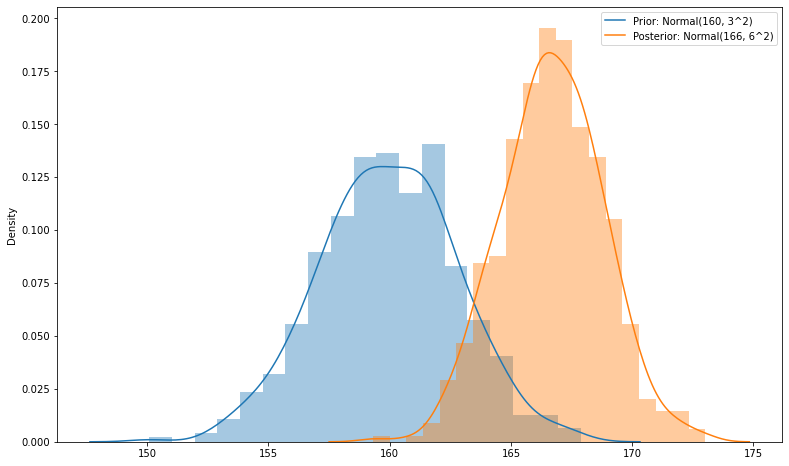

In [4]:
data = np.array([174, 158, 194, 167])
n = len(data)
sigma = 6.
mu_0 = 160.
sigma_0 = 3.

new_sigma = (1/(sigma_0**2) + n/(sigma**2))**(-1/2)
new_mu = new_sigma**2 * (mu_0/(sigma_0**2)+(np.sum(data))/(sigma**2))

prior_dist = pyro.distributions.Normal(mu_0, sigma_0)
prior_samples = np.array([pyro.sample("prior", prior_dist) for i in range(500)])
posterior_dist = pyro.distributions.Normal(new_mu, new_sigma)
posterior_samples = np.array([pyro.sample("posterior", posterior_dist) for i in range(500)])

sns.distplot(prior_samples, kde=True)
sns.distplot(posterior_samples, kde=True)
plt.gcf().set_size_inches(13, 8)
plt.legend(labels=["Prior: Normal(160, 3^2)", "Posterior: Normal(" + str(int(new_mu)) + ", 6^2)"])

## Exercise 4:
Prove that the Beta distribution is a conjugate prior distribution for the Geometric likelihood.

In order to compute the posterior we use Bayes' Theorem:

$$ p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)} \propto p(x|\theta)p(\theta)$$

$p(\theta)$ is the probability density function of the prior distribution, in our case the Beta distribution with parameters $\alpha$ and $\beta$:

$$ p(\theta|\alpha, \beta) \propto \theta^{\alpha-1} (1-\theta)^{\beta-1} $$

$p(x|\theta)$ is the likelihood function for $\theta$ given that the data $x$ follows a geometric distribution with parameter $\theta$, so in pur case the likelihood function will be:

$$ p(\theta|x, \alpha, \beta) = \prod_{i=0}^{n} (1-\theta)^{x_i} \theta = \theta^n (1-\theta)^{\sum_{i=0}^n x_i}$$

Now we can compute the postirior using Bayes' theorem:

\begin{align*}
p(\theta|x) &\propto p(x|\theta)p(\theta) \\
&\propto \theta^n (1-\theta)^{\sum_{i=0}^n x_i} p(x|\theta)p(\theta)\\
&\propto \theta^{(\alpha + n)-1}(1-\theta)^{\left(\beta + \sum_{i=0}^n x_i\right)-1}
\end{align*}

We can clearly see that the distribution of the posterior is a Beta distribution with parameters $\alpha' = \alpha +n$ and $\beta' = \beta + \sum_{i=0}^n x_i$.